In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
with open("omni2_all_years.dat") as f:
    print(f.readline()) #read first line

1963   1  0 1771 99 99 999 999 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 9999999. 999.9 9999. 999.9 999.9 9.999 99.99 9999999. 999.9 9999. 999.9 999.9 9.999 999.99 999.99 999.9  7  33    -6  119 999999.99 99999.99 99999.99 99999.99 99999.99 99999.99  0   3 999.9 999.9 99999 99999 99.9



In [17]:
df = pd.read_csv("omni2_all_years.dat",
                delim_whitespace=True,
                usecols=[0,1,2,39,40,50],
                names=["Year", "DOY", "Hour", "R", "Dst", "F10.7"]) 
#columns 1, 2, 3 giving the year, day of year (DOY), and hour of day of each measurement
#column 40: the sunspot number (R) - the number of spots on the surface of the Sun, indicating how active it is
#column 41: the Dst index - an hourly magnetic activity index measured at Earth’s surface, in nT
#column 51: the F10.7 index - the radio flux at 10.7cm (i.e. how bright the Sun is at that wavelength), in solar flux units (sfu)
#see if there is a connection between conditions of the Sun(R and F10.7) and magnetic conditions at Earth (Dst)

In [18]:
df.head()

,Year,DOY,Hour,R,Dst,F10.7
0,1963,1,0,33,-6,999.9
1,1963,1,1,33,-5,999.9
2,1963,1,2,33,-5,999.9
3,1963,1,3,33,-3,999.9
4,1963,1,4,33,-3,999.9


In [19]:
df.index = pd.to_datetime(df["Year"] * 100000 + df["DOY"] * 100 + df["Hour"], format="%Y%j%H") #combine columns into one column
df = df.drop(columns=["Year", "DOY", "Hour"])

In [20]:
df.head()

,R,Dst,F10.7
1963-01-01 00:00:00,33,-6,999.9
1963-01-01 01:00:00,33,-5,999.9
1963-01-01 02:00:00,33,-5,999.9
1963-01-01 03:00:00,33,-3,999.9
1963-01-01 04:00:00,33,-3,999.9


In [21]:
#data graps infilled with 9s, replace these occurences with NaN
df = df.replace({"R":999,
                 "Dst":99999,
                 "F10.7":999.9}, np.nan)

In [22]:
df.head()

,R,Dst,F10.7
1963-01-01 00:00:00,33.0,-6.0,NaN
1963-01-01 01:00:00,33.0,-5.0,NaN
1963-01-01 02:00:00,33.0,-5.0,NaN
1963-01-01 03:00:00,33.0,-3.0,NaN
1963-01-01 04:00:00,33.0,-3.0,NaN


In [23]:
#is the data really sampled every hour and are there any gaps?
print("Dataframe shape: ", df.shape)
dt = (df.index[-1] - df.index[0])
print("Number of hours between start and end dates: ", dt.total_seconds()/3600 + 1)

Dataframe shape:  (525960, 3)
Number of hours between start and end dates:  525960.0


In [24]:
h, d, y = 24, 365, 55
print(f"{h} hours/day * {d} days/year * {y} years = {h*d*y} hours")

24 hours/day * 365 days/year * 55 years = 481800 hours


<AxesSubplot:xlabel='R'>

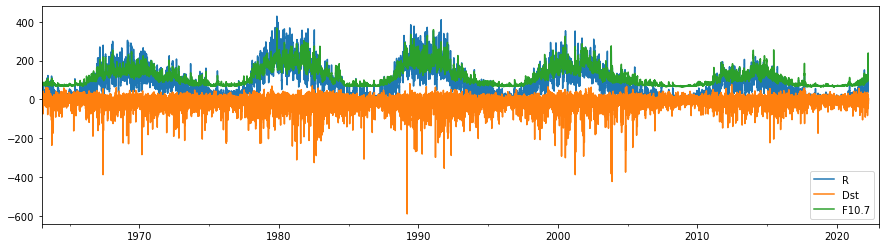

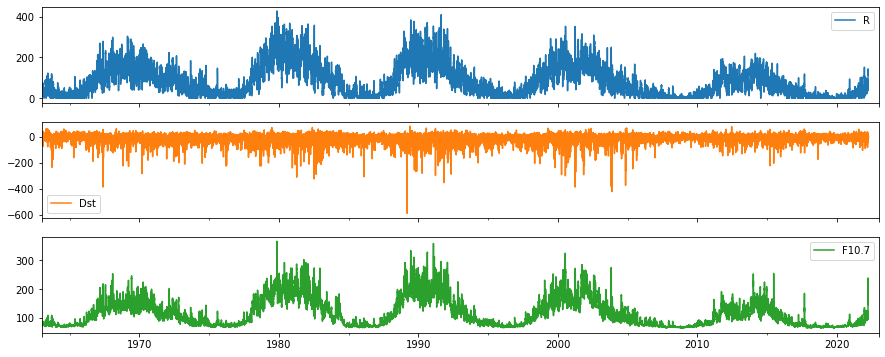

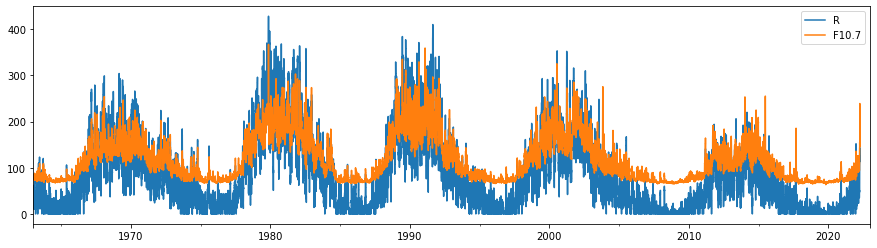

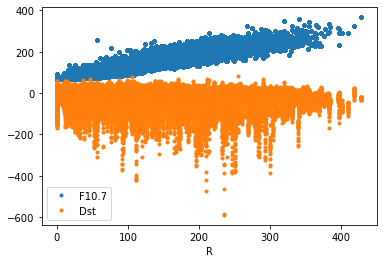

In [25]:
df.plot(figsize=(15,4)) #plotting all the time series on one axis
df.plot(subplots=True, figsize=(15,6)) #plotting them all on separate subplots to see them more clearly (sharing the x axis)
df.plot(y=["R", "F10.7"], figsize=(15,4)) #plotting a selection of columns
df.plot(x="R", y=["F10.7", "Dst"], style='.') #plotting two of the variables against one of the others

<AxesSubplot:>

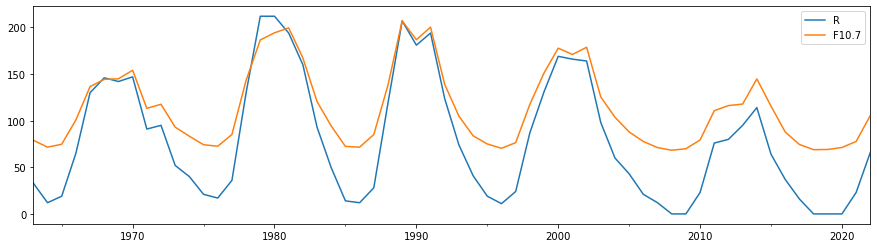

In [34]:
df[["R", "F10.7"]].resample("1y").median().plot(figsize=(15,4)) #reduce noise using resample method

<AxesSubplot:>

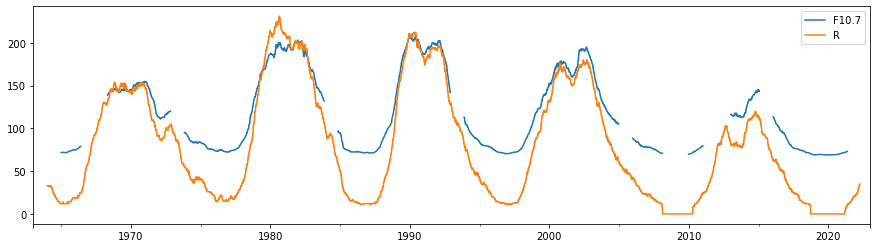

In [35]:
df[["F10.7", "R"]].rolling(24*365).median().plot(figsize=(15,4)) #reduce noise using rolling method

<AxesSubplot:>

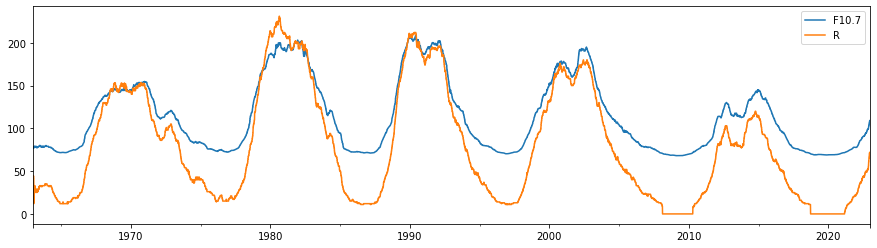

In [37]:
#2022 noticed appearance of some gaps in the F10.7 time series as by default no gaps are allowed within each window calculated
#this can be changed with the min_periods argument
df[["F10.7", "R"]].rolling(24*365, min_periods=1).median().plot(figsize=(15,4)) #reduce noise using rolling method

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

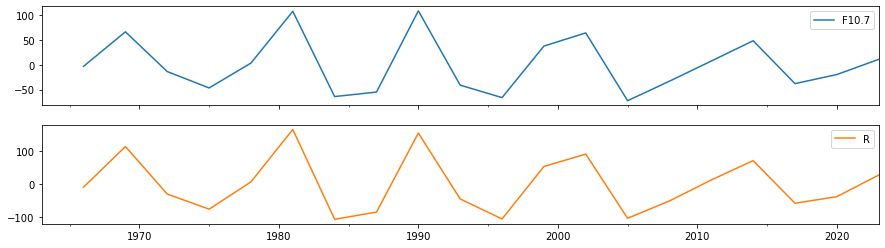

In [38]:
df[["F10.7", "R"]].resample("3y").median().diff().plot(subplots=True, figsize=(15,4))
#incorporate differencing to more clearly isolate the periodic signal

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

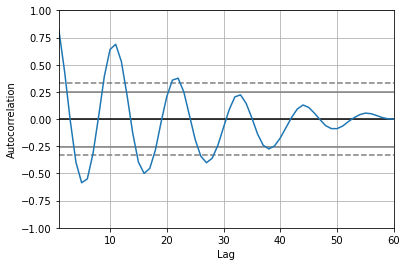

In [39]:
#from previous graph the maximas are separated by rouhgly 10 years, but this periodicity can also be identified via:
pd.plotting.autocorrelation_plot(df["R"].resample("1y").median())
#applying it to the downsampled yearly time series makes this a lot quicker

In [42]:
#see if Dst has correlation to R, variations in Dst tend to occur in discrete events called geomagnetic storms where Dst drops below -100nT
Dst_count = df["Dst"].where(df["Dst"]<-100).resample("1y").count()
Dst_count = Dst_count.reindex(df.index, method="bfill")

<AxesSubplot:>

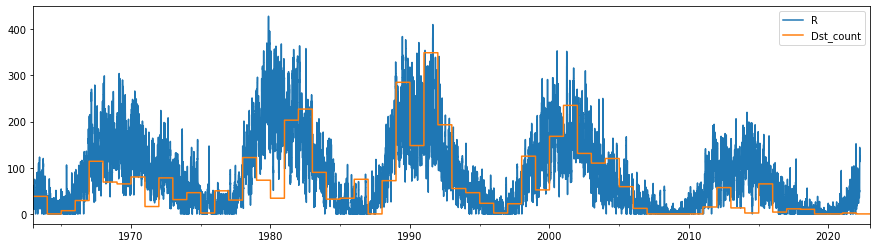

In [43]:
df["Dst_count"] = Dst_count
df.plot(y=["R", "Dst_count"], figsize=(15,4))

In [46]:
#took 6 most recent solar cycles from https://en.wikipedia.org/wiki/List_of_solar_cycles
minima = ["1964-10", "1976-03", "1986-09", "1996-08", "2008-12", "2019-12"]
df_daily = df.resample("1D").mean()

def split_into_cycles(df):
    #returns a list of dataframes, one for each solar cycle
    cycles = []
    #split by solar cycle
    for start, end in zip(minima[0:-1], minima[1:]):
        cycle = df[start:end]
        #convert from dates to days from minimum
        cycle.index = (cycle.index - cycle.index[0]).days
        #extend so that each cycle lasts a full 5000 days (filled with nan)
        ix = pd.Int64Index(np.arange(0,5000))
        #use reindex to fix them all to the same length
        cycle.reindex(ix)
        cycles.append(cycle)
    return cycles

cycles = split_into_cycles(df_daily)
print(cycles)

[         R        Dst  F10.7  Dst_count
0     25.0 -10.750000   72.0        0.0
1     18.0  -5.666667   71.6        0.0
2      0.0  -1.416667   71.8        0.0
3      0.0  -7.458333   70.8        0.0
4      0.0 -11.583333   71.6        0.0
...    ...        ...    ...        ...
4195  64.0 -75.583333   85.5       50.0
4196  61.0 -58.125000   87.1       50.0
4197  54.0 -44.541667   84.0       50.0
4198  45.0 -29.833333   82.4       50.0
4199  37.0 -25.291667   82.7       50.0

[4200 rows x 4 columns],          R        Dst  F10.7  Dst_count
0      0.0 -20.708333   67.7       50.0
1      0.0 -21.375000   68.1       50.0
2      0.0 -26.625000   67.4       50.0
3      0.0 -18.708333   67.4       50.0
4      0.0 -14.416667   67.6       50.0
...    ...        ...    ...        ...
3861   0.0 -35.791667   68.5       75.0
3862   0.0 -24.500000   68.9       75.0
3863   0.0 -20.708333   70.3       75.0
3864  11.0 -18.791667   71.5       75.0
3865  12.0 -16.958333   71.6       75.0

[3866 rows x

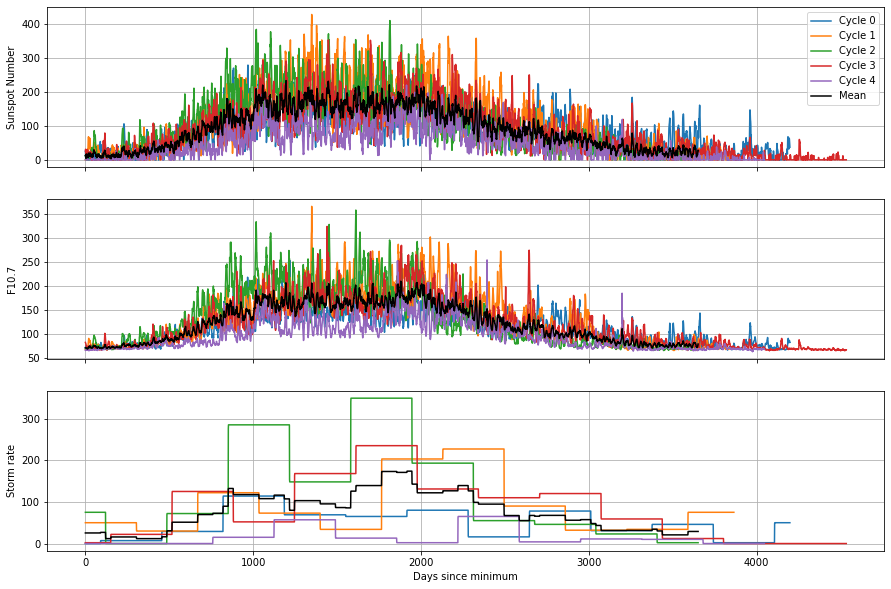

In [47]:
fig, axes = plt.subplots(3, 1, figsize=(15,10), sharex=True) #sharex to link the x-axes on each plot
for i, cycle in enumerate(cycles):
    cycle["R"].plot(ax=axes[0], label=f"Cycle {i}")
    cycle["F10.7"].plot(ax=axes[1])
    cycle["Dst_count"].plot(ax=axes[2])
N_cycles = len(cycles)
(sum(cycles)["R"]/N_cycles).plot(ax=axes[0], color="black", label="Mean")
(sum(cycles)["F10.7"]/N_cycles).plot(ax=axes[1], color="black")
(sum(cycles)["Dst_count"]/N_cycles).plot(ax=axes[2], color="black")
axes[0].legend()
axes[0].set_ylabel("Sunspot Number")
axes[1].set_ylabel("F10.7")
axes[2].set_ylabel("Storm rate")
axes[2].set_xlabel("Days since minimum")
for ax in axes:
    ax.grid()